<a href="https://colab.research.google.com/github/146790g/TextBook-colab_tfbook/blob/master/Xray_VGG16_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深層学習 VGG16モデルを用いたＸ線写真の解析

In [ ]:
%tensorflow_version 2.x

In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls -lh '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/data'

total 8.0K
drwx------ 4 root root 4.0K Jun 23 04:53 train
drwx------ 4 root root 4.0K Jun 23 04:53 validation


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import os
#import Pillow
#from PIL import Image
#import opencv
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers

from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np




#num_train = 1000              # 訓練データの画像数
#num_validation = 1000          # テストデータの画像数

img_h, img_w = 150, 150
channels = 3
batch_size = 32               # ミニバッチのサイズ
train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/data/train' # 訓練データのフォルダー
validation_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/data/validation' # テストデータのフォルダー
result_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/results'        # VGG16の出力結果を保存するフォルダー

    


### VGG16とFC層を結合したモデルの構築

In [ ]:
 ## VGG16モデルと学習済み重みを読み込む
vgg16_model = VGG16(include_top=False,        # 全結合層は層（FC）は読み込まない
                    weights='imagenet',       # ImageNetで学習した重みを利用
                    input_shape=(150, 150, 3) # 入力データの形状
                   )
# VGG16モデルのサマリを出力
print('VGG16モデルのサマリ')
vgg16_model.summary()

# VGG16のblock1_conv1からblock4_poolまでを凍結
# block5のみを学習可能にする
vgg16_model.trainable = True
set_trainable = False
for layer in vgg16_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:        
        layer.trainable = True
    else:
        layer.trainable = False
    
## 凍結後のサマリを出力
print('凍結後のサマリ')
vgg16_model.summary()

## VGG16モデルと独自のFC層を連結した計算モデルを構築
# Sequentialオブジェクトを生成
model = Sequential()

# VGG16モデルを追加
model.add(vgg16_model)
# Flatten層
model.add(Flatten())
# 全結合層
model.add(Dense(256,                 # ニューロン数は256
                activation='relu'    # 活性化関数はReLU
                ))
#第８層（出力層）
model.add(Dense(1, activation='sigmoid', name='sigmoid'))

# VGG16に独自のFC層を結合したモデルのサマリを出力
print('結合後のサマリ')
model.summary()    
     
     
     
  

VGG16モデルのサマリ
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)

In [ ]:
## モデルのコンパイル
# 最適化はRMSpropで行う
# 学習率を小さくしたのはファインチューニングを

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

In [ ]:
%pwd

'/content'

### データ拡張

In [ ]:

img_h, img_w = 150, 150
channels = 3
batch_size = 32               # ミニバッチのサイズ
#train_data_dir = 'content/data/train' # 訓練データのフォルダー
#validation_data_dir = 'content/data/validation' # テストデータのフォルダー
#result_dir = 'results'        # VGG16の出力結果を保存するフォルダー  


## 訓練データを読み込むジェネレーターを生成
# データ拡張を行う
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,      # 40度の範囲でランダムに回転させる
    width_shift_range=0.2,  # 横サイズの0.2の割合でランダムに水平移動
    height_shift_range=0.2, # 縦サイズの0.2の割合でランダムに垂直移動
    horizontal_flip=True,   # 水平方向にランダムに反転、左右の入れ替え
    zoom_range=0.2,         # ランダムに拡大
    shear_range=0.2         # シアー変換をかける
)


# Dog vs Catの訓練データを生成するするジェネレーター
train_generator = train_datagen.flow_from_directory(
    train_data_dir,             # 訓練データのフォルダー
    target_size=(img_h, img_w), # 画像をリサイズ
    batch_size=batch_size,      # ミニバッチのサイズ
    class_mode='binary'         # 出力層は二値のラベルが必要
)


## テストデータを読み込むジェネレーターを生成
test_datagen = ImageDataGenerator(rescale=1.0 / 255)


# Dog vs Catのテストデータを生成するするジェネレーター
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,        # テストデータのフォルダー
    target_size=(img_h, img_w), # 画像をリサイズ
    batch_size=batch_size,      # ミニバッチのサイズ
    class_mode='binary'         # 出力層は二値のラベルが必要
)

Found 5218 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
epochs=50
num_train = 5218
num_validation = 624

## 学習を行う

# 訓練データのジェネレーターのサイズ：63
print(len(train_generator))
# 訓練データの数をミニバッチのサイズで割った値：62
print(num_train//batch_size)
# テストデータのジェネレーターのサイズ：25
print(len(validation_generator))
# テストデータの数をミニバッチのサイズで割った値：25
print(num_validation//batch_size)

# モデルのファインチューニング
history = model.fit_generator(
    
    # 訓練データのジェネレーター
    generator=train_generator,
    # 各エポックにおけるステップ数として
    # 訓練データの数をミニバッチのサイズで割った値を指定
    steps_per_epoch=num_train//batch_size,
    # エポック数（学習回数）
    epochs=epochs,
    # テストデータのジェネレーター
    validation_data=validation_generator,
    # テストにおける各エポックにおけるステップ数として
    # テストデータの数をミニバッチのサイズで割った値を指定
    validation_steps=num_validation//batch_size
)

164
163
20
19
Epoch 1/50
 18/163 [==>...........................] - ETA: 15:51 - loss: 0.5531 - accuracy: 0.7326

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 84 could not be retrieved. It could be because a worker has died.
  UserWarning)


 75/163 [============>.................] - ETA: 9:32 - loss: 0.3805 - accuracy: 0.8241

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)


103/163 [=================>............] - ETA: 6:38 - loss: 0.3367 - accuracy: 0.8472

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


135/163 [=======================>......] - ETA: 3:12 - loss: 0.3106 - accuracy: 0.8620

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 132 could not be retrieved. It could be because a worker has died.
  UserWarning)


163/163 [==============================] - 1215s 7s/step - loss: 0.2910 - accuracy: 0.8710 - val_loss: 0.4309 - val_accuracy: 0.8865
Epoch 2/50
163/163 [==============================] - 109s 671ms/step - loss: 0.1639 - accuracy: 0.9362 - val_loss: 0.5657 - val_accuracy: 0.8564
Epoch 3/50
163/163 [==============================] - 109s 666ms/step - loss: 0.1482 - accuracy: 0.9441 - val_loss: 0.0734 - val_accuracy: 0.9155
Epoch 4/50
163/163 [==============================] - 107s 658ms/step - loss: 0.1306 - accuracy: 0.9476 - val_loss: 0.1607 - val_accuracy: 0.9088
Epoch 5/50
163/163 [==============================] - 107s 654ms/step - loss: 0.1262 - accuracy: 0.9503 - val_loss: 0.1372 - val_accuracy: 0.8936
Epoch 6/50
163/163 [==============================] - 107s 658ms/step - loss: 0.1223 - accuracy: 0.9533 - val_loss: 0.4174 - val_accuracy: 0.8801
Epoch 7/50
163/163 [==============================] - 107s 654ms/step - loss: 0.1094 - accuracy: 0.9589 - val_loss: 0.0905 - val_accuracy

In [ ]:
result_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/results'
model.save_weights(os.path.join(result_dir,'finetuning.h5'))

In [ ]:
type(history)
history.history

{'accuracy': [0.87099886,
  0.93617433,
  0.94408023,
  0.9475511,
  0.9502507,
  0.9533359,
  0.95892787,
  0.9591207,
  0.9620131,
  0.96586967,
  0.9668338,
  0.9651074,
  0.9670287,
  0.97011185,
  0.9695334,
  0.9706903,
  0.96895486,
  0.9730042,
  0.9712688,
  0.9723926,
  0.9730411,
  0.97589666,
  0.9770536,
  0.9712688,
  0.9760895,
  0.9760353,
  0.9745927,
  0.9766104,
  0.97905356,
  0.9774393,
  0.9797532,
  0.9778249,
  0.9776321,
  0.9805245,
  0.97589666,
  0.9772464,
  0.9766104,
  0.9833204,
  0.9785962,
  0.98168147,
  0.98245275,
  0.9807173,
  0.98033166,
  0.9810199,
  0.9821567,
  0.9830312,
  0.98360974,
  0.98360974,
  0.98140335,
  0.9791747],
 'loss': [0.29047743736479303,
  0.16475467377540184,
  0.14855698915898824,
  0.13139328702608938,
  0.12688411305222758,
  0.12135064022632074,
  0.10997254147190375,
  0.10387971825147752,
  0.0984265713087246,
  0.0975755151769601,
  0.08967112304285066,
  0.09229920624806745,
  0.086421560730757,
  0.08129873966731

In [ ]:
np.mean(history.history['accuracy'][45:50])

0.9821657

In [ ]:
np.mean(history.history['val_accuracy'][45:50])

0.9351351380348205

epochが、46番から５０番までの精度の平均値を算出すると、  
訓練データ：精度：98.2 ％  
テストデータ：精度：93.5％  
であった。


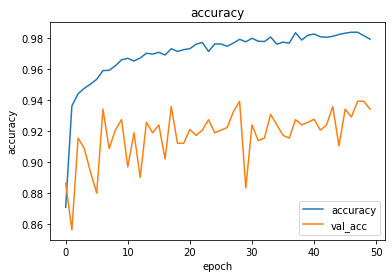

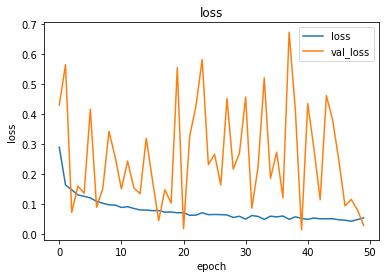

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_acc")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
    
# 損失と精度をグラフに出力
plot_acc_loss(history)